# Rat Trypsin (RT) Mechanical Relay - demo

In [1]:
import sys
# Please append the appropriate project folder path below
sys.path.append('/Users/Nix/PycharmProjects/MechanicalRelay/rigidityGraph')

import os.path as path
import numpy as np
import pandas as pd
from rg.base import BaseRG
from rg.core import LoadKbTable, RGCore
from natsort import natsorted
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
      
RT = dict()
prots = ["holo", "apo"]

## Load the statistically learned data obatined from all-atom molecular dynamics

In [2]:
RT["holo"] = dict()
RT["apo"] = dict()
for prot in prots:
    tab = LoadKbTable(filename=f"{prot}RT_rigidity_data.txt", input_path="./dataset/")
    kb_tab = tab.load_table()
    if prot == "apo":
        # The windows from which the conformational changes are observed are used.
        kb_tab = kb_tab.drop(columns=[str(i) for i in range(1,251)])
    print(f"Shape of the {prot}RT data: {kb_tab.shape}")
    RT[prot]["kb_tab"] = kb_tab

Shape of the holoRT data: (26503, 1007)
Shape of the apoRT data: (23165, 757)


**Note:**<br>
For each system (apoRT and holoRT) the rigidity matrix is constructed and spectral decomposed to obtain the eigen modes. This demo is focussed on mechanical relay and hence for detailed statistical analysis of obtaining prominent modes, please refer to **N. Raj, T. Click, H. Yang and J.-W. Chu, Comput. Struct.Biotechnol. J., 2021, 19, 5309–5320.** and the code and demo jupyter notebook can be found in https://data.mendeley.com/datasets/mv3tzvgjjz/2

## Construct rigidity graph and statistical analysis

In [3]:
# This may take few minutes to complete 
interSegs = ("S1A", "INH") # segids of protein and inhibitor
ss_bonds = [(7,137), (25,41), (173,197), (148,162), (116, 183), (109,210), (5,55), (14,38), (30,51)]

for prot in prots: 
    eigval = dict()
    eigvec = dict()
    resids = dict()
    rigmat = dict()

    for struc in ["BB","BS","SS"]:
        print(f"Executing {prot}RT-{struc} ....")
        if prot == "holo":
            core = RGCore(RT[prot]["kb_tab"], interSegs=interSegs, sskey=struc, exclude_disul=True, disul_bonds=ss_bonds)
        if prot == "apo":
            core = RGCore(RT[prot]["kb_tab"], segid="S1A", sskey=struc, exclude_disul=True, disul_bonds=ss_bonds)
        #pers[struc] = core.average_mode_content()
        resids[struc] = core.get_resids()                       
        eigval[struc], eigvec[struc] = core.eigh_decom()
        rigmat[struc] = core.rigidity_mat()
    RT[prot]["rigmat"] = rigmat
    RT[prot]["eigval"] = eigval
    RT[prot]["eigvec"] = eigvec
    RT[prot]["resids"] = resids

Executing holoRT-BB ....
Executing holoRT-BS ....
Executing holoRT-SS ....
Executing apoRT-BB ....
Executing apoRT-BS ....
Executing apoRT-SS ....


In [8]:
# For residue number and name mappings
import rg.extras as extras
pdb_data = extras.parse_pdb("/Users/nix/PycharmProjects/MGTools/PDB/3TGI.pdb")
## Add calcium ion in the data
pdb_data = pdb_data.append({'resid' : '800' , 
                            'resno' : '224', 
                            'chain_id': "E", 
                            'node_id': "E800CAL",
                            'atom': 'CA',
                            'resi_name': "CAL",
                            'x':float(-8.669),
                            'y':float(-75.041),
                            'z':float(-13.418),
                            'Record name':'ATOM'
                           } , ignore_index=True)
pdbno = pdb_data.resid.unique()[:223].tolist()
pdbno.insert(224, "CA")

# Get the amino acid formatted for labelling
pdb_aa = extras.get_pdb_aaresid("/Users/nix/PycharmProjects/MGTools/PDB/3TGI.pdb")[:223]
pdb_aa = np.insert(pdb_aa, len(pdb_aa), "CA")

from natsort import natsorted
idx2aa = dict(zip(natsorted(RT["apo"]["resids"]["BB"]), pdb_aa))
idx2num = dict(zip(natsorted(RT["apo"]["resids"]["BB"]), pdbno))
aa2idx = dict(zip(pdb_aa,natsorted(RT["apo"]["resids"]["BB"])))
ss_res = RT["apo"]["resids"]["SS"]
ss_idx = [i for i in range(1,200)]
ss_idx2res = dict(zip(ss_idx, ss_res))
ss_idx2aa = dict(zip(ss_idx, [idx2aa[i]for i in ss_res]))
ss_aa2idx = dict(zip([idx2aa[i]for i in ss_res],ss_idx))

## Obtain the strongly coupled residue pairs for each system

In [5]:
from rg.MechRelay.utils import *

Aidx2idx = dict(zip(natsorted(RT["holo"]["resids"]["BB"][:224]), range(1,225)))

aRmat = dict()
hRmat = dict()
for sskey in ["BB","BS","SS"]:
    if sskey == "BB":
        Npos = 224
    if sskey == "BS":
        Npos = 223
    if sskey == "SS":
        Npos = 199
        
    aRmat[sskey] = build_rigidity_matrix_prommodes(val=RT["apo"]["eigval"][sskey], vec=RT["apo"]["eigvec"][sskey],
                                              pmodes=promModes["apo"][sskey], clean=True)
    hRmat[sskey] = build_rigidity_matrix_prommodes(val=RT["holo"]["eigval"][sskey], vec=RT["holo"]["eigvec"][sskey],
                                              pmodes=promModes["holo"][sskey], clean=True)

## Calculate the mechanical responses
Get the residue pairs with $|\Delta{k}_{IJ}| > 25\%$


############### BB ###############


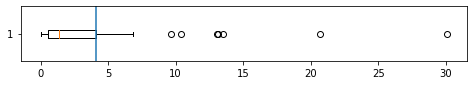

           kIJ(apoRT)  kIJ(holoRT)  kIJ(apoRT)-kIJ(holoRT)
resI resJ                                                 
I16  N143   11.087350     4.667109                6.420241
V17  D189   15.131744    28.265699              -13.133955
N34  Q64    13.200654    20.071378               -6.870724
R67  Q81     4.176705     8.322807               -4.146102
L68  Q81     9.905444    22.948907              -13.043463
N72  V75     3.401881     7.470713               -4.068832
     CA     24.738599    54.783303              -30.044704
V75  CA     10.453939    23.968305              -13.514366
D95  N100   14.020307     3.594493               10.425814
G196 V213   16.597280     6.923306                9.673974
W215 V227    0.684005    21.362305              -20.678300
Look for ON/OFF residues pairs in BB
Empty DataFrame
Columns: [a, h, a-h]
Index: []

############### SS ###############


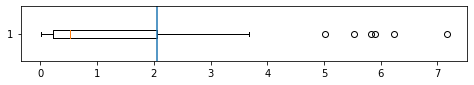

           kIJ(apoRT)  kIJ(holoRT)  kIJ(apoRT)-kIJ(holoRT)
resI resJ                                                 
Q30  S139    7.967695     5.422648                2.545046
S32  H40     0.000295     3.671466               -3.671172
A56  D102    2.064899     4.651103               -2.586203
H57  D102   15.241059     8.077308                7.163752
E70  E80    11.320806     5.424273                5.896533
     CA     53.827204    47.599518                6.227687
E77  CA     17.562946    22.588701               -5.025755
E80  CA     39.776210    45.304675               -5.528465
D189 A221    1.583128     3.644753               -2.061625
S214 T229    7.967430     5.472340                2.495091
W215 V227    0.000000     5.820566               -5.820566
Look for ON/OFF residues pairs in SS
                  a         h       a-h
resI resJ                              
S32  H40   0.000295  3.671466 -3.671172
H40  E151  0.619322  0.000037  0.619285
H57  R96   1.893090  0.003328  1.889

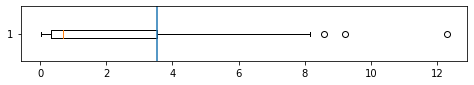

           kIJ(apoRT)  kIJ(holoRT)  kIJ(apoRT)-kIJ(holoRT)
resI resJ                                                 
A56  D102   11.916089     5.181708                6.734380
G69  R117    6.725788    12.017706               -5.291917
E77  E80     6.203350    14.771679               -8.568329
R96  W215    8.160188     0.000000                8.160188
N143 N150    8.448550    11.529220               -3.080671
S146 C220    2.286671    11.518449               -9.231778
Y172 P225    5.022891    17.316854              -12.293963
D189 A221    1.546810     5.591538               -4.044728
C191 D194   15.053652    19.014496               -3.960844
Look for ON/OFF residues pairs in BS
                  a    h       a-h
resI resJ                         
R96  W215  8.160188  0.0  8.160188


In [6]:
delta_KIJ = {} 
deltaKIJ_cut = {}
for sskey in ["BB","SS", "BS"]:
    print()
    print(f"{'#'*15} {sskey} {'#'*15}")
    if sskey == "BB":
        Npos = 224  # includes Ca2+ ion as a residue
        ssres = None
    if sskey == "SS":
        ssres = ss_res
        Npos = 199 # 24 Gly residues are there
    if sskey == "BS":
        ssres=None
        Npos = 223 
        
    aidx = get_ridity_indices(rigpro_mat=aRmat[sskey],
                              rig_mat=RT["apo"]["rigmat"][sskey], Npos=Npos, ssres=ssres)
    hidx = get_ridity_indices(rigpro_mat=hRmat[sskey],
                              rig_mat=RT["holo"]["rigmat"][sskey], Npos=Npos, ssres=ssres, 
                              mapping=Aidx2idx)
    pairs = merge_list_of_tuples(aidx, hidx)   
    delta_KIJ[sskey] = allostery(merged_pairs=pairs, arigmat=RT["apo"]["rigmat"][sskey], 
                           hrigmat=RT["holo"]["rigmat"][sskey], mapping=Aidx2idx)
    Q3, max_whisk = plot_get_whiskers(delta_KIJ[sskey]["a-h"])
    deltaKIJ_cut[sskey] = np.trunc(Q3)
    tmp = delta_KIJ[sskey][(abs(delta_KIJ[sskey]["a-h"]) > deltaKIJ_cut[sskey])]
    
    df = rename_IJ_df(tmp, mapping=idx2aa)
    df.columns = ["kIJ(apoRT)", "kIJ(holoRT)", "kIJ(apoRT)-kIJ(holoRT)"]
    print(df)
    
    print(f"Look for ON/OFF residues pairs in {sskey}")
    on_off = delta_KIJ[sskey][((np.round(delta_KIJ[sskey]["a"],2)==0) & (np.round(delta_KIJ[sskey]["h"],2) !=0)) | 
                              ((np.round(delta_KIJ[sskey]["h"],2)==0) & (np.round(delta_KIJ[sskey]["a"],2) !=0))]
    print(rename_IJ_df(on_off[abs(on_off["a-h"]) > 0.5], mapping=idx2aa))

## Plot the prominent mechanical resposnses ($|\Delta{k}_{IJ}| > 25\%$) as routes 

1. A line is put between two marks if a common residue is shared or if they have residues of nearby sequences (mostly  2, no more than 4 residues)
2. The symmetry is exploited to represent the mechanical routes. See **Figure 3A** in the manuscript.

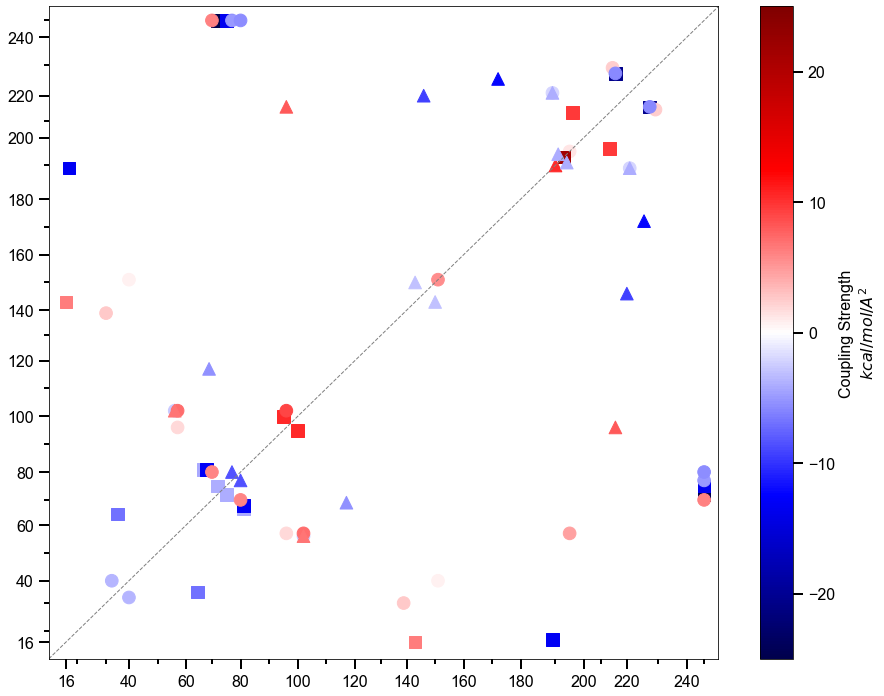

In [9]:
# Plot
from matplotlib.ticker import FixedLocator
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap


# Figure rendering style for publication
def publication_style(fontsize):
    plt.rc('font', family='Arial', serif="Arial", weight='normal')
    #plt.rc('text', usetex=False)
    plt.rc('xtick', color='k', labelsize=fontsize, direction='out')
    plt.rc('ytick', color='k', labelsize=fontsize, direction='out')
    plt.rc('axes', labelsize=fontsize+2)
    plt.rc('axes', labelweight='normal')
    plt.rc('lines', markersize=1.2)
    plt.rc('lines', linewidth=1)
    plt.rc('legend', fontsize=fontsize)
    plt.rc('xtick.major', size=10, width=2, pad=5)
    plt.rc('xtick.minor', size=5, width=2, pad=5)
    plt.rc('ytick.major', size=10, width=2, pad=5)
    plt.rc('ytick.minor', size=5, width=2, pad=5)

# pos is A dictionary with nodes as keys and positions as values. Positions should be sequences of length 2.
#pos = {point: point for point in data_2_plot.index.values}

g = nx.Graph()
publication_style(fontsize=16)
fig, ax = plt.subplots(1, figsize=(15,12))
annotate = False

colors = ["magenta", "violet", "white", "gold", "orange"]
colors = ["purple", "magenta", "white", "orange", "saddlebrown"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


# Residues in contact with BPTI are included explicitly
g.add_node((177,177),strength=1.2, pos=(177,177))
g.add_node((175,175),strength=21.65, pos=(175,175))
g.add_node((172,172),strength=10.5, pos=(172,172))
g.add_node((131,131),strength=5.6, pos=(131,131))

_pos = {n:g.nodes[n]["pos"] for n in g.nodes}

nx.draw_networkx_nodes(g, pos=_pos, nodelist = [(177,177),(131,131)], node_size=160,
                       ax=ax, node_shape="o",node_color=[1.2,5.6], cmap=plt.cm.seismic, vmin=-25, vmax=25)
nx.draw_networkx_nodes(g, pos=_pos, nodelist = [(175,175),], node_size=160,
                                ax=ax, node_shape="s",node_color=[21.65], cmap=plt.cm.seismic, vmin=-25, vmax=25)
nx.draw_networkx_nodes(g, pos=_pos, nodelist = [(172,172),], node_size=160,
                                ax=ax, node_shape="^",node_color=[10.5], cmap=plt.cm.seismic, vmin=-25, vmax=25)

labels = {n:(idx2aa[n[0]],idx2aa[n[1]]) for n in g.nodes if n != (1,223) and n != (223,1)}

if annotate:
    nx.draw_networkx_labels(g, _pos, labels)

###############

g_BB = nx.Graph()
BB_2_plot = delta_KIJ["BB"]["a-h"][abs(delta_KIJ["BB"]["a-h"]) > deltaKIJ_cut["BB"]].dropna()
BB_2_plot = create_dups(BB_2_plot)

for k in BB_2_plot.index.values:
    g_BB.add_node(k,strength=BB_2_plot.loc[k], pos=k)



BB_weights = [float(g_BB.nodes[n]["strength"]) for n in g_BB.nodes]
BB_pos = {n: g_BB.nodes[n]["pos"] for n in g_BB.nodes}

_nodes = nx.draw_networkx_nodes(g_BB, pos=BB_pos, nodelist = list(BB_2_plot.index.values), node_size=160,
                                node_shape="s",ax=ax, node_color=BB_weights, 
                                cmap=plt.cm.seismic, vmin=-25, vmax=25)

labels = {n:(idx2aa[n[0]],idx2aa[n[1]]) for n in g_BB.nodes}
if annotate:
    nx.draw_networkx_labels(g_BB, BB_pos, labels, fontsize=8)

#################

g_SS = nx.Graph()
SS_2_plot = delta_KIJ["SS"]["a-h"][abs(delta_KIJ["SS"]["a-h"]) > deltaKIJ_cut["SS"]].dropna()
SS_2_plot = pd.concat([SS_2_plot, delta_KIJ["SS"]["a-h"].loc[[(40,78)]]])
SS_2_plot = pd.concat([SS_2_plot, delta_KIJ["SS"]["a-h"].loc[[(23,131)]]])
SS_2_plot = create_dups(SS_2_plot)

for k in SS_2_plot.index.values:
    g_SS.add_node(k,strength=SS_2_plot.loc[k], pos=k)

# Residues undergoing conformational changes and present in prominent modes with low weight cutoff
# if present in other prominent modes included
g_SS.add_node((40,78),strength=SS_2_plot.loc[(40,78)], pos=(40,78))
g_SS.add_node((23,131),strength=0.62, pos=(23,131))
g_SS.add_node((78,84),strength=9.03, pos=(78,84))
g_SS.add_node((177,40),strength=4.63, pos=(177,40))
SS_weights = [float(g_SS.nodes[n]["strength"]) for n in g_SS.nodes]
SS_pos = {n: g_SS.nodes[n]["pos"] for n in g_SS.nodes}


_nodes = nx.draw_networkx_nodes(g_SS, pos=SS_pos, nodelist = list(g_SS.nodes), node_size=160,
                                node_shape="o",ax=ax, node_color=SS_weights, 
                                cmap=plt.cm.seismic, vmin=-25, vmax=25)

labels = {n:(idx2aa[n[0]],idx2aa[n[1]]) for n in g_SS.nodes}
if annotate:
    nx.draw_networkx_labels(g_SS, SS_pos, labels, fontsize=8)
    
################

g_BS = nx.Graph()

BS_2_plot = delta_KIJ["BS"]["a-h"][abs(delta_KIJ["BS"]["a-h"]) > deltaKIJ_cut["BS"]].dropna()
BS_2_plot = create_dups(BS_2_plot)

for k in BS_2_plot.index.values:
    g_BS.add_node(k,strength=BS_2_plot.loc[k], pos=k)

BS_weights = [float(g_BS.nodes[n]["strength"]) for n in g_BS.nodes]
BS_pos = {n: g_BS.nodes[n]["pos"] for n in g_BS.nodes}

_nodes = nx.draw_networkx_nodes(g_BS, pos=BS_pos, nodelist = list(BS_2_plot.index.values), node_size=160,
                                node_shape="^",ax=ax, node_color=BS_weights, 
                                cmap=plt.cm.seismic, vmin=-25, vmax=25)
labels = {n:(idx2aa[n[0]],idx2aa[n[1]]) for n in g_BS.nodes}
if annotate:
    nx.draw_networkx_labels(g_BS, BS_pos, labels, fontsize=8)


ax.plot([-5,1,2,50,100,224,230],[-5,1,2,50,100,224,230], linestyle="--", color="Gray")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

cb = plt.colorbar(_nodes)
cb.set_label(label=r'Coupling Strength''\n''$kcal/mol/A^2$', weight="normal", fontsize=16)
cblabel = ax.yaxis.label
cb.ax.tick_params(axis='y', labelsize=16)

xticklabels = [16, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
yticklabels = [16, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
aa2idx = dict(zip(pdbno,natsorted(RT["apo"]["resids"]["BB"])))
xtickpositions = [aa2idx[str(i)] for i in xticklabels]
ytickpositions = [aa2idx[str(i)] for i in yticklabels]
ax.get_xaxis().set_major_locator(FixedLocator(xtickpositions))
ax.set_xticklabels(xticklabels)
ax.get_yaxis().set_major_locator(FixedLocator(ytickpositions))
ax.set_yticklabels(yticklabels)

mxticklabels = [20, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, "CA"]
myticklabels = [20, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, "CA"]
minor_xtickpositions = [aa2idx[str(i)] for i in mxticklabels]
minor_ytickpositions = [aa2idx[str(i)] for i in myticklabels]
ax.get_xaxis().set_minor_locator(FixedLocator(minor_xtickpositions))
ax.get_yaxis().set_minor_locator(FixedLocator(minor_ytickpositions))
ax.tick_params(bottom=True, left=True, which='minor')
#ax.tick_params(left=True, which='minor')
ax.set_xlim(-5,224+5)
ax.set_ylim(-5,224+5)
plt.show()